## Dependency Section

In [ ]:
!pip freeze > requirements.txt
# !pip install -r requirements.txt

In [ ]:
!pip install langsmith chromadb sentence-transformers langchain-community

### Vector DB - Cosine Similarity

## Data Preparation - Adding Metadata

In [3]:
import json
from uuid import uuid4
from datetime import datetime

def make_chunks(chat_data):
    chunks = []
    i = 0
    while i < len(chat_data):
        if chat_data[i]["speaker"] == "Human":
            human_msg = chat_data[i]["message"]
            ai_msg = chat_data[i + 1]["message"] if (i + 1 < len(chat_data) and chat_data[i + 1]["speaker"] == "AI") else ""
            
            chunk = {
                # "id": f"turn_{i}_{uuid4().hex[:6]}",
                "text": human_msg.strip(),
                "timestamp": datetime.now().isoformat(),
                "metadata": {
                    "ai_response": ai_msg.strip(),
                    "exchange_number": i // 2 + 1
                }
            }
            chunks.append(chunk)
        i += 1
    return chunks


# Example
with open("chat.json", "r") as f:
    chat_data = json.load(f)

chunks = make_chunks(chat_data)

with open("chunks_ready_try.json", "w") as f:
    json.dump(chunks, f, indent=2)

print(f"Created {len(chunks)} chunks ✅")


Created 25 chunks ✅


In [2]:
import json
with open("chunks_ready.json", "r") as f:
    chunks = json.load(f)

print(f"Loaded {len(chunks)} chunks ✅")
print(chunks[0])

Loaded 25 chunks ✅
{'id': 'turn_0_430ba2', 'text': 'I’ve been feeling off lately, like I’m just going through the motions every day.', 'metadata': {'speaker': 'human', 'ai_reply': 'That sounds really hard. When life starts feeling repetitive or dull, it’s often a sign your mind needs a break or some new stimulus. Can you tell me what’s been draining you lately?', 'turn_number': 0, 'emotion': 'test', 'topic': 'test'}}


## Vector Database with L2 and Cosine Similarity

### Vector DB Setup - Euclidean (L2) Similarity

In [ ]:
import os
import json
from uuid import uuid4
import chromadb
from sentence_transformers import SentenceTransformer

# ---------- STEP 3: Initialize persistent Chroma ----------
# Create persistent directory
persist_dir = "./chroma_store"
os.makedirs(persist_dir, exist_ok=True)

# Persistent client
client = chromadb.PersistentClient(path=persist_dir)

# Create or get collection
collection = client.get_or_create_collection("mental_health_chat_mpnet_l2", metadata={"hnsw:space": "l2"})
print("✅ Connected to persistent Chroma collection.")


# ---------- STEP 4: Generate embeddings ----------
# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("all-mpnet-base-v2")

ids = [c["id"] for c in chunks]
texts = [c["text"] for c in chunks]
metadatas = [c["metadata"] for c in chunks]

embeddings = model.encode(texts).tolist() 

# ---------- STEP 5: Add to Chroma (if not already present) ----------
existing_ids = set(collection.get(ids=ids).get("ids", []))
new_chunks = [(i, t, m, e) for i, t, m, e in zip(ids, texts, metadatas, embeddings) if i not in existing_ids]

if new_chunks:
    collection.add(
        ids=[i for i, _, _, _ in new_chunks],
        documents=[t for _, t, _, _ in new_chunks],
        metadatas=[m for _, _, m, _ in new_chunks],
        embeddings=[e for _, _, _, e in new_chunks],
    )
    print(f"✅ Added {len(new_chunks)} new chunks to persistent Chroma.")
else:
    print("ℹ️ No new chunks to add. Database already up-to-date.")


# ---------- STEP 6: Example Query ----------
query = "I keep feeling tired and unmotivated lately."
query_emb = model.encode([query]).tolist()

results = collection.query(query_embeddings=query_emb, n_results=1, include=["documents", "metadatas", "distances"])

print("\n🔍 Top Matches:")
for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
    print(f"\n🗣️ Human said: {doc}")
    print(f"🤖 AI replied: {meta['ai_reply']}")
    print("-" * 60)

✅ Connected to persistent Chroma collection.
✅ Added 25 new chunks to persistent Chroma.

🔍 Top Matches:

🗣️ Human said: I’ve been feeling off lately, like I’m just going through the motions every day.
🤖 AI replied: That sounds really hard. When life starts feeling repetitive or dull, it’s often a sign your mind needs a break or some new stimulus. Can you tell me what’s been draining you lately?
------------------------------------------------------------


### Vector DB Setup - Cosine Similarity

In [5]:
import os
import numpy as np
from uuid import uuid4
import chromadb
from sentence_transformers import SentenceTransformer

# ---------- STEP 3: Initialize persistent Chroma ----------
# Create persistent directory
persist_dir = "./chroma_store"
os.makedirs(persist_dir, exist_ok=True)

# Persistent client
client = chromadb.PersistentClient(path=persist_dir)

# Create or get collection
collection = client.get_or_create_collection("mental_health_chat_mpnet_cos", metadata={"hnsw:space": "cosine"})
print("✅ Connected to persistent Chroma collection.")


# ---------- STEP 4: Generate embeddings ----------
model = SentenceTransformer("all-mpnet-base-v2")

ids = [c["id"] for c in chunks]
texts = [c["text"] for c in chunks]
metadatas = [c["metadata"] for c in chunks]

embeddings = model.encode(texts, convert_to_numpy=True)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

embeddings = embeddings.tolist()

# ---------- STEP 5: Add to Chroma (if not already present) ----------
existing_ids = set(collection.get(ids=ids).get("ids", []))
new_chunks = [(i, t, m, e) for i, t, m, e in zip(ids, texts, metadatas, embeddings) if i not in existing_ids]

if new_chunks:
    collection.add(
        ids=[i for i, _, _, _ in new_chunks],
        documents=[t for _, t, _, _ in new_chunks],
        metadatas=[m for _, _, m, _ in new_chunks],
        embeddings=[e for _, _, _, e in new_chunks],
    )
    print(f"✅ Added {len(new_chunks)} new chunks to persistent Chroma.")
else:
    print("ℹ️ No new chunks to add. Database already up-to-date.")


# ---------- STEP 6: Example Query ----------
query = "I keep feeling tired and unmotivated lately."
query_emb = model.encode([query]).tolist()

results = collection.query(query_embeddings=query_emb, n_results=1, include=["documents", "metadatas", "distances"])

print("\n🔍 Top Matches:")
for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
    print(f"\n🗣️ Human said: {doc}")
    print(f"🤖 AI replied: {meta['ai_reply']}")
    print("-" * 60) 

✅ Connected to persistent Chroma collection.
✅ Added 25 new chunks to persistent Chroma.

🔍 Top Matches:

🗣️ Human said: I’ve been feeling off lately, like I’m just going through the motions every day.
🤖 AI replied: That sounds really hard. When life starts feeling repetitive or dull, it’s often a sign your mind needs a break or some new stimulus. Can you tell me what’s been draining you lately?
------------------------------------------------------------


## Retrieval for Vector DB - L2 and Cosine Similarity

### Vector Retrieval - L2 Similarity

In [8]:
import os
import chromadb
from sentence_transformers import SentenceTransformer

# ---------- STEP 1: Connect to Persistent Chroma ----------
persist_dir = "./chroma_store"

# Connect to the existing persistent Chroma store
client = chromadb.PersistentClient(path=persist_dir)

# Load the same collection used before
collection = client.get_or_create_collection("mental_health_chat_mpnet_l2")
print("✅ Connected to persistent Chroma collection.")

# ---------- STEP 2: Load the same embedding model ----------
model = SentenceTransformer("all-mpnet-base-v2")

# ---------- STEP 3: Define a query function ----------
def query_chroma(query_text: str, n_results: int = 3):
    """Query the persistent Chroma DB and print top results."""
    # Generate embedding for query
    query_emb = model.encode([query_text]).tolist()

    # Search in Chroma
    results = collection.query(
        query_embeddings=query_emb,
        n_results=n_results,
        include=["documents", "metadatas", "distances"],
    )

    # Print results
    print(f"\n🔍 Query: {query_text}")
    print("-" * 60)
    for i, (doc, meta, dist) in enumerate(
        zip(results["documents"][0], results["metadatas"][0], results["distances"][0])
    ):
        print(f"🏷️ Match {i+1} (distance: {dist:.4f})")
        print(f"🗣️ Human said: {doc}")
        print(f"🤖 AI replied: {meta.get('ai_reply', 'N/A')}")
        print("-" * 60)

# ---------- STEP 4: Run a sample query ----------
if __name__ == "__main__":
    user_query = "I've been feeling anxious and can't sleep well."
    query_chroma(user_query, n_results=3)


✅ Connected to persistent Chroma collection.

🔍 Query: I've been feeling anxious and can't sleep well.
------------------------------------------------------------


### Vector Retrieval - Cosine Similarity

In [7]:
import os
import chromadb
from sentence_transformers import SentenceTransformer

# ---------- STEP 1: Connect to Persistent Chroma ----------
persist_dir = "./chroma_store"

# Connect to the existing persistent Chroma store
client = chromadb.PersistentClient(path=persist_dir)

# Load the same collection used before
collection = client.get_or_create_collection("mental_health_chat_mpnet_cos")
print("✅ Connected to persistent Chroma collection.")

# ---------- STEP 2: Load the same embedding model ----------
model = SentenceTransformer("all-mpnet-base-v2")

# ---------- STEP 3: Define a query function ----------
def query_chroma(query_text: str, n_results: int = 3):
    """Query the persistent Chroma DB and print top results."""
    # Generate embedding for query
    query_emb = model.encode([query_text]).tolist()

    # Search in Chroma
    results = collection.query(
        query_embeddings=query_emb,
        n_results=n_results,
        include=["documents", "metadatas", "distances"],
    )

    # Print results
    print(f"\n🔍 Query: {query_text}")
    print("-" * 60)
    for i, (doc, meta, dist) in enumerate(
        zip(results["documents"][0], results["metadatas"][0], results["distances"][0])
    ):
        print(f"🏷️ Match {i+1} (distance: {dist:.4f})")
        print(f"🗣️ Human said: {doc}")
        print(f"🤖 AI replied: {meta.get('ai_reply', 'N/A')}")
        print("-" * 60)

# ---------- STEP 4: Run a sample query ----------
if __name__ == "__main__":
    user_query = "I've been feeling anxious and can't sleep well."
    query_chroma(user_query, n_results=3)


✅ Connected to persistent Chroma collection.

🔍 Query: I've been feeling anxious and can't sleep well.
------------------------------------------------------------
🏷️ Match 1 (distance: 0.5093)
🗣️ Human said: I’ve also been sleeping too much, even on weekends.
🤖 AI replied: Oversleeping can be your body’s way of coping with stress or sadness. Would you say your sleep feels restful or more like escape?
------------------------------------------------------------
🏷️ Match 2 (distance: 0.5784)
🗣️ Human said: I’ve been feeling off lately, like I’m just going through the motions every day.
🤖 AI replied: That sounds really hard. When life starts feeling repetitive or dull, it’s often a sign your mind needs a break or some new stimulus. Can you tell me what’s been draining you lately?
------------------------------------------------------------
🏷️ Match 3 (distance: 0.6258)
🗣️ Human said: I’ve been listening to calm piano tracks; they help a bit.
🤖 AI replied: That’s a great start. Music can 

## LangSmith Integration

In [ ]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client(api_key='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')
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
print(prompt)

## Emotional Embeddings

In [4]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

api_key = os.environ.get("API_KEY")
# The client uses the GROQ_API_KEY environment variable automatically
# You only need to specify the base_url to use Groq's endpoint.
client = OpenAI(
    api_key=api_key,
    base_url="https://api.groq.com/openai/v1",
)

user_query = "I am feeling too lonely, due to which I am unable to sleep at night"

chat_completion = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a master of sentiment analysis. Carefully discern the subtle emotions "
                "underlying each interviewer's question. Analyze questions across 8 dimensions: "
                "joy, acceptance, fear, surprise, sadness, disgust, anger, and anticipation. "
                "Score each from 1-10. Your answer must be a valid python list so that it can "
                "be parsed directly, with no extra content! Format: "
                "[{\"analysis\": <REASON>, \"dim\": \"joy\", \"score\": <SCORE>}, ...]"
            )
        },
        {
            "role": "user",
            "content": user_query
        }
    ],
    temperature=0.1,
    max_tokens=1024,
    stream=False,
    stop=None,
)

# Access the result
print(chat_completion.choices[0].message.content)

[{"analysis": "The user is expressing a negative emotional state of loneliness, which is impacting their ability to sleep, indicating a lack of happiness or joy", "dim": "joy", "score": 2}, 
{"analysis": "The user is acknowledging their emotional state and seeking help, showing a degree of self-awareness and acceptance", "dim": "acceptance", "score": 6}, 
{"analysis": "The user's inability to sleep may be causing fear or anxiety about their well-being or the future", "dim": "fear", "score": 7}, 
{"analysis": "There is no indication of surprise in the user's statement, as they are describing a ongoing emotional state", "dim": "surprise", "score": 1}, 
{"analysis": "The user is explicitly stating that they are feeling lonely, which is a sad or melancholic emotion", "dim": "sadness", "score": 9}, 
{"analysis": "There is no indication of disgust in the user's statement, as they are describing a personal emotional state rather than a reaction to something external", "dim": "disgust", "score

In [14]:
import json
import ast
from datetime import datetime

# 1. Get the raw content from your Groq completion
raw_output = chat_completion.choices[0].message.content
# query_text = "Today I am feeling very confident about my upcoming exams."

try:
    # 2. Parse the string into a Python list
    # We use ast.literal_eval as a safer alternative to eval() for python lists/dicts
    # Or json.loads() if the LLM output is strictly valid JSON format
    parsed_data = ast.literal_eval(raw_output.strip())

    # 3. Create the final structured object
    structured_log = {
        "timestamp": datetime.now().isoformat(),
        "query": user_query,
        "model": 'llama-3.3-70b-versatile',
        "emotion_results": parsed_data
    }

    # 4. Output or save the results
    print(json.dumps(structured_log, indent=4))

except Exception as e:
    print(f"Failed to parse LLM output: {e}")
    print(f"Raw output was: {raw_output}")

{
    "timestamp": "2026-01-03T18:29:02.882503",
    "query": "I am feeling too lonely, due to which I am unable to sleep at night",
    "model": "llama-3.3-70b-versatile",
    "emotion_results": [
        {
            "analysis": "The statement expresses a sense of isolation and disconnection, which is a strong indicator of negative emotions",
            "dim": "joy",
            "score": 1
        },
        {
            "analysis": "The feeling of loneliness implies a lack of acceptance from others or oneself, contributing to a low acceptance score",
            "dim": "acceptance",
            "score": 2
        },
        {
            "analysis": "The inability to sleep at night due to loneliness may evoke a fear of being alone or a fear of the emotional pain",
            "dim": "fear",
            "score": 6
        },
        {
            "analysis": "There is no element of surprise in the statement, as it describes a ongoing emotional state",
            "dim": "surprise"

In [15]:
# Extract dimension scores
dimension_scores = {
    item["dim"]: item["score"]
    for item in structured_log["emotion_results"]
}
print(dimension_scores)

# Sorted Alphabetically
# acceptance, anger, anticipation, disgust, fear, joy, sadness, surprise

{'joy': 1, 'acceptance': 2, 'fear': 6, 'surprise': 1, 'sadness': 9, 'disgust': 2, 'anger': 3, 'anticipation': 2}


In [16]:
# Define the desired alphabetical order
dimensions = sorted(item["dim"] for item in structured_log["emotion_results"])
print(dimensions)

# Create a mapping of dimension to score
score_map = {item["dim"]: item["score"] for item in structured_log["emotion_results"]}
print(score_map)
# Generate the score list in alphabetical order
score_list = [score_map[dim] for dim in dimensions]

print(score_list)

['acceptance', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
{'joy': 1, 'acceptance': 2, 'fear': 6, 'surprise': 1, 'sadness': 9, 'disgust': 2, 'anger': 3, 'anticipation': 2}
[2, 3, 2, 2, 6, 1, 9, 1]


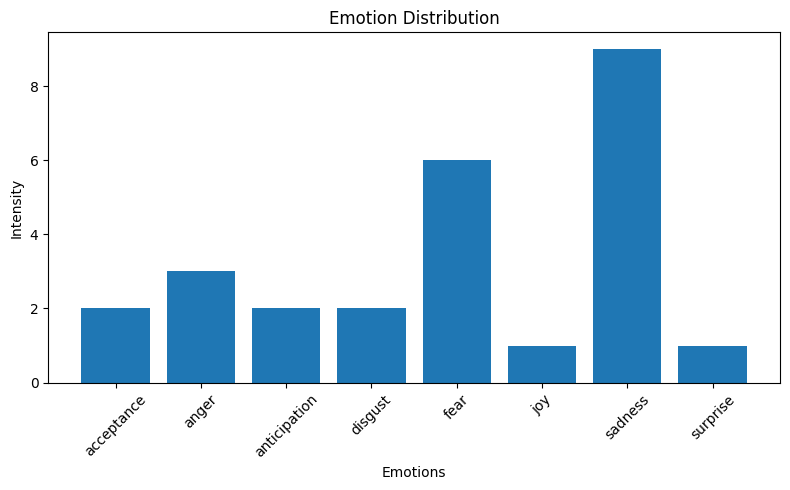

In [17]:
import matplotlib.pyplot as plt

# Emotion data
emotions = dict(sorted(dimension_scores.items()))
# dict(sorted(dimension_scores.items()))

# Separate keys and values
labels = list(emotions.keys())
values = list(emotions.values())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel('Emotions')
plt.ylabel('Intensity')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


## Custom Chroma DB For Emotion Embeddings

In [ ]:
import chromadb
from chromadb.config import Settings

# Persistent DB (saved to disk)
client = chromadb.Client(
    Settings(
        persist_directory="./emotion_vector_db",
        anonymized_telemetry=False
    )
)

# Create / get collection
collection = client.get_or_create_collection(
    name="emotion_vectors",
    metadata={"description": "8D emotion embeddings"}
)


In [ ]:
# Example emotion vectors
embeddings = [
    [3, 2, 2, 2, 4, 1, 8, 1],
    [7, 1, 1, 1, 1, 5, 2, 1],
    [1, 6, 3, 4, 2, 1, 5, 2]
]

# Optional: normalize (recommended)
embeddings = [[v / 10 for v in vec] for vec in embeddings]

documents = [
    "User feeling lonely and sleepless",
    "User feeling calm and content",
    "User feeling angry and anxious"
]

metadatas = [
    {"label": "lonely"},
    {"label": "calm"},
    {"label": "angry"}
]

ids = ["doc1", "doc2", "doc3"]

collection.add(
    embeddings=embeddings,
    documents=documents,
    metadatas=metadatas,
    ids=ids
)


In [ ]:
client.persist()


In [ ]:
query_vector = [2, 2, 2, 2, 3, 1, 7, 1]
query_vector = [v / 10 for v in query_vector]

results = collection.query(
    query_embeddings=[query_vector],
    n_results=2
)

print(results)


In [ ]:
{
  'ids': [['doc1', 'doc3']],
  'documents': [['User feeling lonely...', 'User feeling angry...']],
  'metadatas': [[{'label': 'lonely'}, {'label': 'angry'}]],
  'distances': [[0.12, 0.34]]
}


In [ ]:
results = collection.query(
    query_embeddings=[query_vector],
    n_results=3,
    where={"label": "lonely"}
)


In [ ]:
collection.update(
    ids=["doc1"],
    embeddings=[[0.3,0.2,0.2,0.2,0.4,0.1,0.8,0.1]],
    documents=["Updated emotional state"]
)


In [ ]:
collection.delete(ids=["doc3"])


In [ ]:
vec = [v / 10 for v in vec]


In [ ]:
assert len(vec) == 8

## Semantic Vector DB

In [1]:
import chromadb
# from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import numpy as np
import os

c:\Users\Rajveer Mathur\Desktop\Emo-Aware-Convo-Systems\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")
def l2_normalize(vectors: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms


In [ ]:
persist_dir = "../chroma_store"
os.makedirs(persist_dir, exist_ok=True)

# Persistent client
client = chromadb.PersistentClient(path=persist_dir)

# Create or get collection
collection = client.get_or_create_collection("semantic_vectors", metadata={"hnsw:space": "cosine"})
print("✅ Connected to persistent Chroma collection.")


In [7]:
import json
with open("..\\data\\chunks_ready.json", "r") as f:
    chat_data = json.load(f)

print(f"Loaded {len(chat_data)} chat chunks.")
# print(chat_data)

Loaded 25 chat chunks.


In [8]:
docs = []
ids = []
for chunk in chat_data:
    docs.append(chunk["text"])
    ids.append(chunk["id"])
# print(docs)

meta = []
for chunk in chat_data:
    structured_log = {
        "timestamp": chunk["timestamp"],
        "ai_response": chunk["ai_response"],
        "emotion_analysis": json.dumps(chunk["emotions_metadata"].get("emotion_scores", {})),
        "emotional_embedding": json.dumps(chunk["emotions_metadata"].get("embedding", []))
    }
    # print(structured_log)
    meta.append(structured_log)

In [9]:
meta[0]

{'timestamp': '2026-01-10T17:30:22.909096',
 'ai_response': 'That sounds really hard. When life starts feeling repetitive or dull, it’s often a sign your mind needs a break or some new stimulus. Can you tell me what’s been draining you lately?',
 'emotion_analysis': '{"acceptance": 6, "anger": 1, "anticipation": 1, "disgust": 2, "fear": 1, "joy": 2, "sadness": 8, "surprise": 1}',
 'emotional_embedding': '[6, 1, 1, 2, 1, 2, 8, 1]'}

In [10]:
# Create embeddings
embeddings = embedding_model.encode(docs, convert_to_numpy=True)

# 🔹 Normalize embeddings
embeddings = l2_normalize(embeddings)

collection.add(
    documents=docs,
    embeddings=embeddings.tolist(),
    metadatas=meta,
    ids=ids
)

In [4]:
query_text = "sleepless"

query_embedding = embedding_model.encode(
    [query_text], convert_to_numpy=True
)

query_embedding = l2_normalize(query_embedding)

results = collection.query(
    query_embeddings=query_embedding.tolist(),
    n_results=2
)

print(results)


NameError: name 'embedding_model' is not defined

In [3]:
collection = client.get_or_create_collection("semantic_vectors")
print(collection.count())


25


In [ ]:
with open("data/chunks_ready.json", "r", encoding="utf-8") as f:
    chat_data = json.load(f)

In [ ]:
for chunk in chat_data:
    emotion_vec = chunk["emotions_metadata"].get("embedding")

emotion_vec

In [ ]:
import json

def l2_to_similarity(l2_distance: float) -> float:
    return 1.0 / (1.0 + l2_distance) # Larger means more similar

def cosine_to_similarity(cosine_distance: float) -> float:
    return 1.0 - cosine_distance

with open("../logs/combined_retrieval_20260116_003820.json", "r", encoding="utf-8") as f:
    chat_data = json.load(f)

intermediate_scores = {}
for sem_result in chat_data["semantic_results"]:
        sem_id = sem_result["id"]
        sem_cosine_distance = cosine_to_similarity(sem_result["distance"])
        # sem_similarity = cosine_to_similarity(sem_cosine_distance)
        intermediate_scores[sem_id] = {"semantic_similarity": sem_cosine_distance, "emotional_similarity": None}

for emo_result in chat_data["emotion_results"]:
    emo_id = emo_result.get("id")
    emo_distance = l2_to_similarity(emo_result.get("distance"))

    if emo_id is None:
        continue  # or handle fallback ID

    if emo_id in intermediate_scores:
        # ID exists → just add emotion distance
        intermediate_scores[emo_id]["emotional_similarity"] = emo_distance
    else:
        # ID missing → create new entry
        intermediate_scores[emo_id] = {
            "semantic_similarity": None,  # safe fallback
            "emotional_similarity": emo_distance
        }


print(intermediate_scores)

{'22a64646-99fb-4edb-ad3c-a836c2095e79': {'semantic_similarity': 0.3713498115539551, 'emotional_similarity': None}, 'c6278e08-63ed-4343-9b3e-c0a329ed059c': {'semantic_similarity': 0.3266386389732361, 'emotional_similarity': None}, '8b4c1d64-817b-4d04-ac60-c963f5d9c67e': {'semantic_similarity': 0.315022349357605, 'emotional_similarity': None}, 'ccd069e3-7c19-4a13-b9ed-7108e9b9f015': {'semantic_similarity': 0.2753537893295288, 'emotional_similarity': 0.1}, '2cf79334-972b-415c-ae2f-46f0c4e57804': {'semantic_similarity': 0.24551045894622803, 'emotional_similarity': None}, 'caa913f4-9a80-4273-b15d-75db8bed3355': {'semantic_similarity': None, 'emotional_similarity': 0.2}, 'baef7b83-aec4-4970-b4ec-dfa9ddc3f057': {'semantic_similarity': None, 'emotional_similarity': 0.1111111111111111}, '7214ecbf-a81d-49e3-b7fa-c3322ee13e07': {'semantic_similarity': None, 'emotional_similarity': 0.08333333333333333}, '7b1d2e8f-ba1c-432b-90bf-49750265b960': {'semantic_similarity': None, 'emotional_similarity': 

In [2]:
min_semantic_similarity = min(
    cosine_to_similarity(r["distance"])
    for r in chat_data["semantic_results"]
)

min_emotional_similarity = min(
    l2_to_similarity(r["distance"])
    for r in chat_data["emotion_results"]
)

In [3]:
min_semantic_similarity, min_emotional_similarity

(0.24551045894622803, 0.07692307692307693)